# Delta Omicron multidms data fit

## Import `Python` modules

In [1]:
import os
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
from scipy.stats import poisson

from timeit import default_timer as timer
%matplotlib inline

import sys
sys.path.append("..")
from multidms.utils import create_homolog_modeling_data, initialize_model_params
from multidms.model import ϕ, g, prox, cost_smooth

## Read in metadata on homolog DMS experiments

Our primary goal is to get a single dataframe that contains all homolog variants encoded with sequencial sites wrt the wt seqences which have been aligned with no gaps - as well as their functional scores. This can then be converted into our model fitting data.

We'll start by collecting all the data for each homolog into a single dataframe containing all experiments
along with a column holding a nested dataframe for all the associated functional scores.

Additionally, we make a dictionary for the homolog wildtype sequences, and a df for the site maps of both sequences

In [2]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel])
    
    # WT Protein sequence
    with open(f"../results/{homolog}/protein.fasta", "r") as seq_file:
        header = seq_file.readline()
        wt_seqs[homolog] = seq_file.readline().strip()

    # Sites
    sites[homolog] = (
        pd.read_csv(f"../results/{homolog}/site_numbering_map.csv")
        .rename({"sequential_site":f"{homolog}_site", "sequential_wt":f"{homolog}_wt"})
        .set_index(["reference_site"])
    )

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
    
# Show the dataframe summarizing all experiments
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
0,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
1,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


Make a list of sites that are present in one homolog, but not the other.

In [3]:
set.symmetric_difference(
    set(sites["Delta"].reset_index()["reference_site"].values.astype(str)), 
    set(sites["Omicron_BA.1"].reset_index()["reference_site"].values.astype(str))
)

{'143', '144', '145', '157', '158', '211', '214a', '214b', '214c', '69', '70'}

## Get functional scores for experiments to be compared

Define input variables

In [340]:
# Define which homologs to compare
homolog_column = 'homolog_exp'
#(homolog_1, homolog_2) = ('Delta-3-1', 'Delta-3-2')
#(homolog_1, homolog_2) = ('Omicron_BA.1-2-1', 'Omicron_BA.1-3-1')
(homolog_1, homolog_2) = ('Delta-3-1', 'Omicron_BA.1-3-1')
#(homolog_1, homolog_2) = ('Omicron_BA.1-1-1', 'Omicron_BA.1-1-2')
reference_homolog = homolog_1

# Other input variables
subs_col = "aa_substitutions_reference"
#func_score_col = "func_score"
shift_func_scores = False
shift_func_scores_nonref = -1.0
clip_y = None # [-5,2.5] # 

subset_data = None
agg_variants = True
min_pre_counts = 100

Make a single dataframe with functional scores from both homologs being compared. If indicated, rescale post-selection counts based on a defined bottleneck.

In [345]:
# Get the data for each homolog to compare
func_score_col = "func_score"
dfs = []
for (i, row) in func_score_data.iterrows():
    homolog = row[homolog_column]
    if homolog in [homolog_1, homolog_2]:
        homolog_df = row['func_sel_scores_df'].copy()
        homolog_df[homolog_column] = homolog
        print(f'Read in {len(homolog_df)} datapoints for {homolog}')
        if (shift_func_scores) and (homolog == homolog_2):
            print(f'Shifting functional scores for {homolog}')
            homolog_df[func_score_col] += shift_func_scores_nonref
        dfs.append(homolog_df)
func_score_df = pd.concat(dfs)
func_score_df.reset_index(drop=True, inplace=True)
func_score_df.aa_substitutions_reference.fillna("", inplace=True)

# Rescale post-counts based on a bottleneck
if True:
    func_score_col = 'log2e'
    pseudocount = 0.1 # 10 #
    dfs = []
    for (h, hdf) in func_score_df.groupby(homolog_column):
        n_post_counts = sum(hdf['post_count'])
        if 'Delta' in h:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        else:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        hdf['orig_post_count'] = hdf['post_count']
        hdf['post_count'] *= scaling_factor
        hdf['post_count_wt'] *= scaling_factor
        print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))
        
        # Recompute enrichment ratios with new counts
        hdf['pre_count_ps'] = hdf['pre_count'] + pseudocount
        hdf['post_count_ps'] = hdf['post_count'] + pseudocount
        hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + pseudocount
        hdf['post_count_wt_ps'] = hdf['post_count_wt'] + pseudocount
        
        total_pre_count = sum(hdf['pre_count_ps'])
        total_post_count = sum(hdf['post_count_ps'])
        
        hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
        hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
        hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
        hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count
        
        hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
        hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
        hdf['e'] = hdf['var_e'] / hdf['wt_e']
        #hdf.dropna(subset=['e'], inplace=True)
        hdf['log2e'] = hdf['e'].apply(lambda x: math.log(x, 2))
        if (shift_func_scores) and (h == homolog_2):
            print(f'Shifting new functional scores for {h}')
            hdf[func_score_col] += shift_func_scores_nonref
        dfs.append(hdf)
        
    func_score_df = pd.concat(dfs)

else:
    func_score_col = "func_score"

Read in 37703 datapoints for Delta-3-1
Read in 125127 datapoints for Omicron_BA.1-3-1
Delta-3-1 4153136 0.02 100000.0
Omicron_BA.1-3-1 72545787 0.0 100000.0


Curate the data.

In [346]:
# Drop variants with mutations to gaps, and variants that have
# a stop codon as the wildtype (occur at position 1253 due to
# renumbering)
gapped_sub_vars = [idx for idx, row in func_score_df.iterrows() if "-" in row.aa_substitutions_reference]
stop_wt_vars = []
for idx, row in func_score_df.iterrows():
    for sub in row[subs_col].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars))
func_score_df.drop(to_drop, inplace=True)

# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= min_pre_counts]
print(f'Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {min_pre_counts} counts before selection, and were filtered out')

# Remove 214a/b/c sites since they cause problems below
# TODO: fix this?
func_score_df = func_score_df[
    ~(func_score_df[subs_col].str.contains('E214a')) &
    ~(func_score_df[subs_col].str.contains('P214b')) &
    ~(func_score_df[subs_col].str.contains('E214c'))
]

# If indicated, clip y values
if clip_y:
    print('Clipping functional scores to a min and max of: ', clip_y)
    func_score_df[func_score_col].clip(*clip_y, inplace=True)

Of 158885 variants, 13673 had fewer than 100 counts before selection, and were filtered out


Compare post-counts distribution to a Poisson distribution with the same mean.

Delta-3-1 1129 1129 0.49
Omicron_BA.1-3-1 1885 1885 0.05


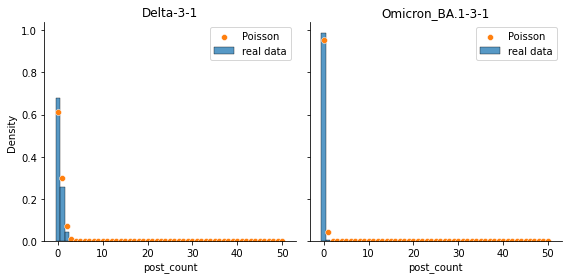

In [347]:
bin_size = 1.0
min_val = -0.5
max_val = 50
bins = onp.arange(min_val, max_val+bin_size, bin_size)

(fig, axs) = plt.subplots(
    ncols=2, sharex=True, sharey=True,
    figsize=(8,4)
)
for (i, (h, hdf)) in enumerate(func_score_df.groupby(homolog_column)):
    
    # Plot real data
    data = hdf[
        (hdf['post_count'].between(0, max_val)) &
        (hdf[subs_col].str.contains('\*'))
    ].copy()
    mean_post_count = data['post_count'].mean()
    print(
        h,
        sum(hdf[subs_col].str.contains('\*')),
        len(data),
        round(mean_post_count, 2)
    )    
    sns.histplot(
        x='post_count', data=data, bins=bins,
        stat='density', label='real data',
        ax=axs[i]
    )
    
    # Plot Poisson distribution
    xs = onp.arange(0, max_val+1, 1)
    poisson_densities = [
        poisson.pmf(x, mean_post_count)
        for x in xs
    ]
    sns.scatterplot(
        x=xs, y=poisson_densities, #bins=bins,
        label='Poisson', ax=axs[i]
    )
    axs[i].set(title=h)
axs[0].legend()
plt.tight_layout()
sns.despine()
plt.show()

Plot the distribution of functional scores

Delta-3-1 wiltype variants 2382
Omicron_BA.1-3-1 wiltype variants 21028
Delta-3-1 variants with muts to stops 1129
Omicron_BA.1-3-1 variants with muts to stops 1885


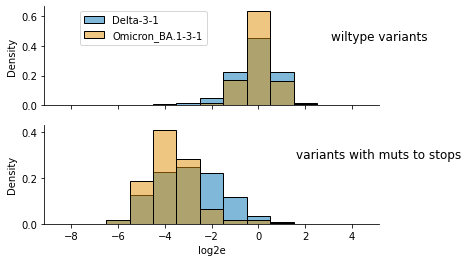

In [344]:
# Initialize a list of dataframes to plot
data_to_plot = []

# Get data for wildtype variants
min_pre_freq = 1e-10 # 0.000020 # 
data = func_score_df[
    (func_score_df[subs_col] == '') &
    (func_score_df['pre_freq'] >= min_pre_freq)
].copy()
data_to_plot.append(('wiltype variants', data))

# Get data for variants with stop codons
data = func_score_df[
    (func_score_df[subs_col].str.contains('\*')) &
    (func_score_df['pre_freq'] >= min_pre_freq)
].copy()
data_to_plot.append(('variants with muts to stops', data))

# Pre-determine bins
min_val = math.floor(func_score_df[func_score_col].min())
max_val = math.ceil(func_score_df[func_score_col].max())
bin_size = 1
bins = onp.arange(min_val - bin_size/2, max_val + bin_size, bin_size)

# Plot data
(fig, axs) = plt.subplots(nrows=2, sharex=True)
pal = sns.color_palette('colorblind')
reverse_func_score_shift = True
for (i, (title, data)) in enumerate(data_to_plot):
    for (c_i, (h, data_h)) in enumerate(data.groupby(homolog_column)):
        data_h = data_h.copy()
        print(h, title, len(data_h))
        if (shift_func_scores) and (h == homolog_2) and (reverse_func_score_shift):
            print(f'Reversing shift in func scores for {h}')
            data_h[func_score_col] -= shift_func_scores_nonref
        sns.histplot(
            x=func_score_col, data=data_h, bins=bins,
            stat='density', color=pal.as_hex()[c_i], label=h,
            alpha=0.5, ax=axs[i]
        )
    axs[i].set_title(title, x=1, y=0.6)
axs[0].legend(bbox_to_anchor=(0.5,1))
sns.despine()
plt.show()

pre_count 252.6669815777043


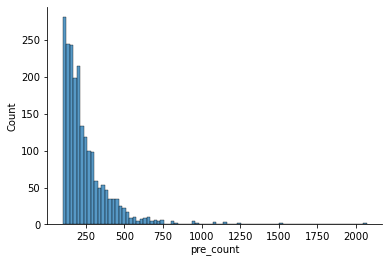

pre_freq 5.221413852337889e-06


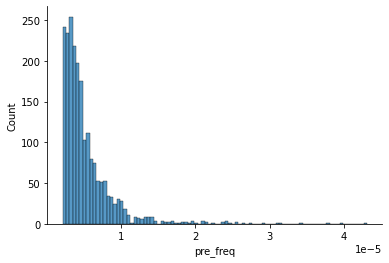

In [335]:
data = func_score_df[
    (func_score_df[subs_col].str.contains('\*')) &
    (func_score_df['homolog_exp'].str.contains('Omicron'))
].copy()
metrics = ['pre_count', 'pre_freq']
for metric in metrics:
    print(metric, data[metric].mean())
    sns.histplot(x=metric, data=data)
    sns.despine()
    plt.show()

In [312]:
data = func_score_df[
    func_score_df[subs_col].str.contains('\*') &
    func_score_df['log2e'].between(-2.2, -1.8) &
    func_score_df['homolog_exp'].str.contains('Omicron')
].copy()
data[[
    func_score_col,
    'e',
    'pre_freq',  'pre_count',
    'post_freq', 'post_count',
    #'pre_freq_wt', 'post_freq_wt',
    #'post_count', 'post_count_wt',
    'homolog_exp'
]].head()

,log2e,e,pre_freq,pre_count,post_freq,post_count,homolog_exp
22430,-2.089763,0.234919,0.000014,717,0.000004,1.594953,Omicron_BA.1-1-1
23560,-2.172645,0.221804,0.000013,690,0.000003,1.403559,Omicron_BA.1-1-1
34081,-2.147121,0.225763,0.000010,496,0.000003,0.893174,Omicron_BA.1-1-1
34501,-2.064982,0.238989,0.000010,490,0.000003,0.956972,Omicron_BA.1-1-1
38877,-2.086607,0.235434,0.000008,432,0.000002,0.765578,Omicron_BA.1-1-1


In [289]:
data['post_count'].mean()

0.488025894084509

For variants with stop codons, does the functional score correlate with the position of the stop codon in the gene? Or number of pre counts?

Showing data for homolog: Delta-3-1
Clipping pre-counts to a max of 1000


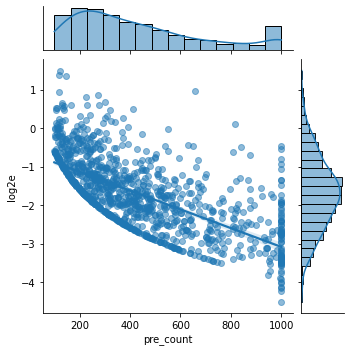

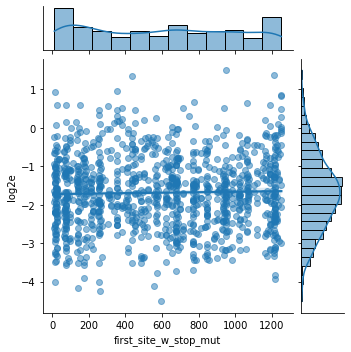

In [299]:
# Get data for variants with stop codons
homolog = reference_homolog # 'Omicron_BA.1-2-1' # 'Delta'
print(f'Showing data for homolog: {homolog}')
data = func_score_df[
    (func_score_df[homolog_column] == homolog) &
    (func_score_df[subs_col].str.contains('\*'))
].copy()

# Identify the first site in a variant to have a stop-
# codon mutation
def get_first_site_with_stop_mut(sub_str):
    sites = []
    for sub in sub_str.split():
        if sub[-1] == '*':
            sites.append(int(sub[1:-1]))
    return sorted(sites)[0]
data['first_site_w_stop_mut'] = data[subs_col].apply(
    lambda x: get_first_site_with_stop_mut(x)
)

# Clip upper bound of pre-counts
max_pre_count = 1000
max_post_count = 50
print(f'Clipping pre-counts to a max of {max_pre_count}')
data['pre_count'].clip(upper=max_pre_count, inplace=True)
data['post_count'].clip(upper=max_post_count, inplace=True)

# Plot data
metrics = ['pre_count', 'first_site_w_stop_mut']
joint_plot = True
for metric in metrics:
    if joint_plot:
        sns.jointplot(
            x=metric, y=func_score_col,
            data=data, kind='reg', height=5,
            joint_kws = {'scatter_kws':dict(alpha=0.5)}
        )
        sns.despine()
        plt.show()
    else:
        plt.figure(figsize=[5,5])
        sns.scatterplot(
            x=metric, y=func_score_col,
            data=data, hue='post_count'
        )
        sns.despine()
        plt.legend(bbox_to_anchor=(1,1))
        plt.show()

Plot the distributions of pre- and post-counts for variants with mutations to stop codons.

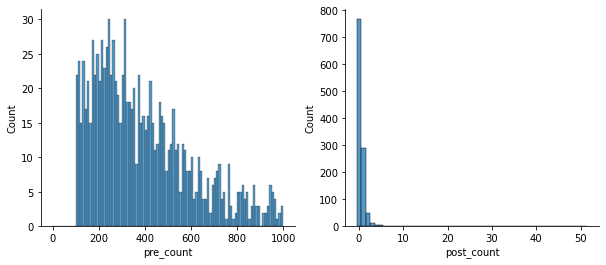

In [300]:
(fig, axs) = plt.subplots(ncols=2, figsize=[10,4])

bins = onp.arange(-0.5,1000.5,10)
sns.histplot(x='pre_count', data=data, bins=bins, ax=axs[0])
#sns.despine()
#plt.show()

bins = onp.arange(-0.5,max_post_count+2,1)
sns.histplot(x='post_count', data=data, bins=bins, ax=axs[1])
sns.despine()
plt.show()

**Observations**: The post-count distribution does not follow my expectations. Given that there are a large number of variants with stop-codon mutations with zero post-counts, I would have assumed the distribution to gradually fall off as post counts increased, following a Poisson distribution, perhaps. However, the fall off is very steep. This seems to suggest that the post-counts distribution does not arise from a purely random process.

Look at the correlation in functional score between homologs (only really works if the "homologs" are replicate experiments of the same library).

In [213]:
data = func_score_df[
    #(func_score_df['pre_count'] > 100) &
    #(func_score_df['post_count'] > 5) &
    (func_score_df[subs_col].str.contains('\*'))
].copy()
data = pd.pivot_table(
    data, index=['barcode', subs_col],
    #values=func_score_col,
    columns=homolog_column
)
data[[func_score_col, 'pre_count']].head(n=10)

log2e  \
homolog_exp                                            Delta-3-1   
barcode          aa_substitutions_reference                        
AAAAAACCCAATGACT N148H F375* V1177A                          NaN   
AAAAAACGCTTCAGTC N121K Y144* T604N G1171S E1202K       -3.508876   
AAAAAACTTACGCAAA R21S E132* A783V R1014G D1163N V1228G       NaN   
AAAAAAGAATATTAAC G769* K814M                           -2.689965   
AAAAAATAACATCAAA D178E W353*                                 NaN   
AAAAAATATATCATCA N122T G769* A1222S                          NaN   
AAAAAATCAATCTAGA A67D D428E S939* E1111A               -2.174445   
AAAAAATTAGCCTACG R19* P82L N679T                       -1.942101   
AAAAACCGATGAGACT P26L D80* T1076I G1085D               -1.446901   
AAAAACGACTGAAACA F157*                                       NaN   

                                                                         \
homolog_exp                                            Omicron_BA.1-3-1   
barcode          aa_substitutions_reference                               
AAAAAACCCAATGACT N148H F375* V1177A                           -1.939127   
AAAAAACGCTTCAGTC N121K Y144* T604N G1171S E1202K                    NaN   
AAAAAACTTACGCAAA R21S E132* A783V R1014G D1163N V1228G        -3.319084   
AAAAAAGAATATTAAC G769* K814M                                        NaN   
AAAAAATAACATCAAA D178E W353*                                  -3.930807   
AAAAAATATATCATCA N122T G769* A1222S                           -2.832359   
AAAAAATCAATCTAGA A67D D428E S939* E1111A                            NaN   
AAAAAATTAGCCTACG R19* P82L N679T                                    NaN   
AAAAACCGATGAGACT P26L D80* T1076I G1085D                            NaN   
AAAAACGACTGAAACA F157*                                        -2.761221   

                                                       pre_count  \
homolog_exp                                            Delta-3-1   
barcode          aa_substitutions_reference                        
AAAAAACCCAATGACT N148H F375* V1177A                          NaN   
AAAAAACGCTTCAGTC N121K Y144* T604N G1171S E1202K          1312.0   
AAAAAACTTACGCAAA R21S E132* A783V R1014G D1163N V1228G       NaN   
AAAAAAGAATATTAAC G769* K814M                              1430.0   
AAAAAATAACATCAAA D178E W353*                                 NaN   
AAAAAATATATCATCA N122T G769* A1222S                          NaN   
AAAAAATCAATCTAGA A67D D428E S939* E1111A                   389.0   
AAAAAATTAGCCTACG R19* P82L N679T                           393.0   
AAAAACCGATGAGACT P26L D80* T1076I G1085D                   182.0   
AAAAACGACTGAAACA F157*                                       NaN   

                                                                         
homolog_exp                                            Omicron_BA.1-3-1  
barcode          aa_substitutions_reference                              
AAAAAACCCAATGACT N148H F375* V1177A                               119.0  
AAAAAACGCTTCAGTC N121K Y144* T604N G1171S E1202K                    NaN  
AAAAAACTTACGCAAA R21S E132* A783V R1014G D1163N V1228G            280.0  
AAAAAAGAATATTAAC G769* K814M                                        NaN  
AAAAAATAACATCAAA D178E W353*                                      568.0  
AAAAAATATATCATCA N122T G769* A1222S                               265.0  
AAAAAATCAATCTAGA A67D D428E S939* E1111A                            NaN  
AAAAAATTAGCCTACG R19* P82L N679T                                    NaN  
AAAAACCGATGAGACT P26L D80* T1076I G1085D                            NaN  
AAAAACGACTGAAACA F157*                                            203.0

In [214]:
data = func_score_df[
    #(func_score_df['pre_count'] > 100) &
    #(func_score_df['post_count'] > 5) &
    (func_score_df[subs_col].str.contains('\*'))
].copy()
data['post_count'].clip(upper=50, inplace=True)
data = pd.pivot_table(
    data, index=['barcode', subs_col],
    values=func_score_col, # 'post_count', # 
    columns=homolog_column
)
print(len(data))
data.dropna(inplace=True)
print(len(data))
if len(data) > 0:
    sns.jointplot(
        x=homolog_1, y=homolog_2,
        data=data, kind='reg', height=5,
        joint_kws = {'scatter_kws':dict(alpha=0.5)}
    )
    plt.show()

3014
0


**Observations:** There is a correlation between functional scores, but there are also a substantial number of points in clouds off of the diagonal, suggesting that at least one of the mechanisms leading to the survival of stop-codon mutations is acting independently between replicates.

Hypothesis: there is a bottleneck in sequencing the library after selection. Some variants don't make it through the bottleneck. But the ones that do get amplified by PCR so that there are many copies. If the sequencing depth is much greater than the bottleneck, then the things that made it through the bottleneck will have counts that are much higher than the things that didn't make it through the bottleneck.
* How to test this hypothesis: 
* Solution: subsample deep sequencing data so that the depth is less than the number of variants that made it through the bottleneck.

Make a contingency table of the above data.

In [215]:
cutoff = -6
ct_dict = {
    key : []
    for key in [
        'index', f'{homolog_1}_low', f'{homolog_1}_high', 'total'
    ]
}
ct_dict['index'] = [
    f'{homolog_2}_high',
    f'{homolog_2}_low',
    'total'
]
ct_dict[f'{homolog_1}_low'] = [
    sum(
        (data[homolog_1] < cutoff) &
        (data[homolog_2] > cutoff)
    ),
    sum(
        (data[homolog_1] < cutoff) &
        (data[homolog_2] < cutoff)
    ),
    sum((data[homolog_1] < cutoff))
]
ct_dict[f'{homolog_1}_high'] = [
    sum(
        (data[homolog_1] > cutoff) &
        (data[homolog_2] > cutoff)
    ),
    sum(
        (data[homolog_1] > cutoff) &
        (data[homolog_2] < cutoff)
    ),
    sum((data[homolog_1] > cutoff))
]
ct_dict['total'] = [
    sum((data[homolog_2] > cutoff)),
    sum((data[homolog_2] < cutoff)),
    len(data)
]
ct_df = pd.DataFrame(ct_dict)
ct_df.set_index('index')

,Delta-3-1_low,Delta-3-1_high,total
index,,,
Omicron_BA.1-3-1_high,0,0,0
Omicron_BA.1-3-1_low,0,0,0
total,0,0,0


**Observations**: By eye, the table shows that the distributions are not completely independent of one another, though they aren't completely correlated either. Thus, it looks like at least one mechanism leading to the survival of stop-codon mutations is common between replicates (e.g., could some cells have multiple genomes, leading to a genotype-phenotype mismatch?).

Before fitting models, option to subset the data, or aggregate data among barcodes that encode the same variant.

In [216]:
if subset_data:
    func_score_df = func_score_df.sample(n=subset_data, random_state=23).reset_index()
if agg_variants:
    func_score_df = func_score_df.groupby([subs_col, homolog_column]).mean().reset_index()
    func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
    func_score_df["post_count"] = func_score_df["post_count"].astype(int)

Option to subset the data to just the reference homolog.

In [217]:
if False:
    func_score_df = func_score_df[
        (func_score_df[homolog_column] == reference_homolog)
    ]

Create a new dataframe in which mutations are all relative to the reference homolog.

In [218]:
(X, y), df, all_subs, site_map = create_homolog_modeling_data(
                            func_score_df, 
                            homolog_column,
                            reference_homolog,
                            subs_col,
                            func_score_col
                        )

Found 8 site(s) lacking data in at least one homolog.
2817 of the 88753 variants were removed because they had mutations at the above sites, leaving 85936 variants.


100%|███████████████████████████████████████████████████████████| 59537/59537 [03:08<00:00, 315.71it/s]


In [219]:
print('Number of datapoints per homolog:')
for (homolog, data) in df.groupby(homolog_column):
    print(homolog, len(data))

Number of datapoints per homolog:
Delta-3-1 26399
Omicron_BA.1-3-1 59537


Fit models

In [220]:
# Params for fitting
maxiter = 2000 # 10000 # 
λ_ridge = 1e-5
clip_str = "-".join([str(c) for c in clip_y]) if clip_y else clip_y
fig_saveas_prefix = (f"tar-{func_score_col}-clipy-{clip_str}"
                    f"-ref-{reference_homolog}"
                    f"-agg-{agg_variants}"
                    f"-sub-{subset_data}"
                    f"-iter-{maxiter}-λ_ridge-{λ_ridge}")

# Initialize the range and minimum of the sigmoid
# from the global epistasis function using the 5th
# and 95th percentile values from the raw data
sig_upper = df[func_score_col].quantile(0.95)
sig_lower = df[func_score_col].quantile(0.05)
sig_range = sig_upper - sig_lower

# Initialize all params
params = initialize_model_params(
    func_score_df[homolog_column].unique(), 
    n_beta_shift_params=X[reference_homolog].shape[1],
    include_alpha=True,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [221]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {cost_smooth(params, (X, y), λ_ridge=0):.2e}")


Pre-Optimization
----------------
cost = 2.64e+00


In [222]:
tol = 1e-6
maxiter = maxiter
start = timer()

solver = ProximalGradient(cost_smooth, prox, tol=tol, maxiter=maxiter)

# First, just fit data on reference homolog
if False:
    print('Fitting model to just the reference homolog')
    params, state = solver.run(
        params, 
        hyperparams_prox = dict(
            clip_stretch=0.0, 
            lock_params= {
                f"S_{reference_homolog}" : jnp.zeros(len(params['β'])),
                f"C_{reference_homolog}" : jnp.zeros(shape=(1,)),
                f"C_{homolog_2}" : jnp.zeros(shape=(1,))
            }
        ),
        data=(
            {reference_homolog : X[reference_homolog]},
            {reference_homolog : y[reference_homolog]}
        ),
        λ_ridge=0
    )

# Next, jointly fit data on both homologs
print('Fitting model to both homologs')
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        clip_stretch=0.0, 
        lock_params= {
            f"S_{reference_homolog}" : jnp.zeros(len(params['β'])),
            f"C_{reference_homolog}" : jnp.zeros(shape=(1,)),
            f"C_{homolog_2}" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=λ_ridge
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_smooth(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")

Fitting model to both homologs

Post-Optimization
-----------------
Full model optimization: 10000 iterations
error = 1.30e-03
cost = 4.41e-01
Wall time for fit: 612.8224213920184


Print summary stats of fit params

In [223]:
for param in ["β", f"S_{reference_homolog}", f"S_{homolog_2}"]:
    print(f"\nFit {param} distribution\n===============")
    if param not in params:
        continue
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)
     
    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)
     
    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")
    
if f'C_{homolog_2}' in params:
    print(f"\nC_{homolog_2}: {params[f'C_{homolog_2}']}")

print(f"\nFit Sigmoid Parameters, α\n================")
for param, value in params['α'].items():
    print(f"{param}: {value}") 

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{func_score_col}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby(homolog_column):
    h_params = {"β":params["β"], "S":params[f"S_{homolog}"], "C":params[f"C_{homolog}"]}
    z_h = ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h
    y_h_pred = g(params["α"], z_h)
    df.loc[hdf.index, f"predicted_{func_score_col}"] = y_h_pred

print(f"Done")


Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -9.40e-01
Median = -5.38e-01
Measures of Dispersion
Minimum = -1.19e+01
Maximum = 8.42e+00
Range = 2.03e+01
Variance = 3.15e+00
Standard Deviation = 1.77e+00

Fit S_Delta-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = 0.00e+00
Median = 0.00e+00
Measures of Dispersion
Minimum = 0.00e+00
Maximum = 0.00e+00
Range = 0.00e+00
Variance = 0.00e+00
Standard Deviation = 0.00e+00

Fit S_Omicron_BA.1-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = -9.68e-02
Median = -2.98e-03
Measures of Dispersion
Minimum = -2.51e+00
Maximum = 2.45e+00
Range = 4.96e+00
Variance = 1.86e-01
Standard Deviation = 4.31e-01

C_Omicron_BA.1-3-1: [0.]

Fit Sigmoid Parameters, α
ge_bias: [-3.02969575]
ge_scale: [3.51640343]
latent_bias: [2.09588403]

Running Predictions
-------------------
Done


Plot predicted vs. observed values

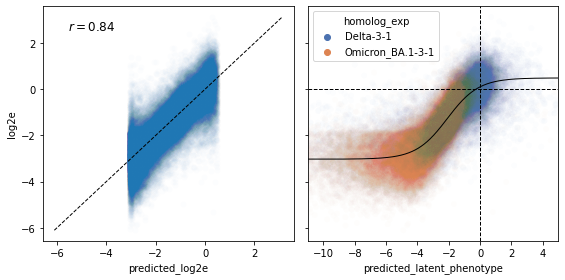

In [224]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], sharey=True)
sns.scatterplot(
    data=df, x=f"predicted_{func_score_col}",
    y=func_score_col,
    #hue=homolog_column,
    alpha=0.01, palette="deep", ax=ax[0],
    legend=True
)

lb = df[[func_score_col, f"predicted_{func_score_col}"]].min().min()
ub = df[[func_score_col, f"predicted_{func_score_col}"]].max().max()

ax[0].plot([lb, ub], [lb, ub], "k--", lw=1)
r = pearsonr(df[func_score_col], df[f'predicted_{func_score_col}'])[0]
ax[0].annotate(f"$r = {r:.2f}$", (.1, .9), xycoords="axes fraction", fontsize=12)

# shape 
sns.scatterplot(
    data=df, x="predicted_latent_phenotype",
    y=func_score_col,
    hue=homolog_column,
    alpha=0.01, palette="deep",
    legend=True, ax=ax[1]
)

ϕ_grid = onp.linspace(
    1.1 * df.predicted_latent_phenotype.min(),
    1.1 * df.predicted_latent_phenotype.max(),
    num=1000
)
shape = (ϕ_grid, g(params["α"], ϕ_grid))
ax[1].plot(*shape, color='k', lw=1)
#ax[1].set_ylim(-11, 1)
ax[1].set_xlim(-11, 5)
plt.axhline(0, color="k", ls="--", lw=1)
plt.axvline(0, color="k", ls="--", lw=1)
fig.savefig(f"{fig_saveas_prefix}-scatter.png")
plt.tight_layout()
#sns.despine()
plt.show()

**Observations**
* For jointly fitting delta/omicron data, the sigmoid often maxes out below 0. Could this be because extreme outliers are dragging it down? Is there a better loss function that would help resolve this?

Plot the distribution of beta and shift parameters.

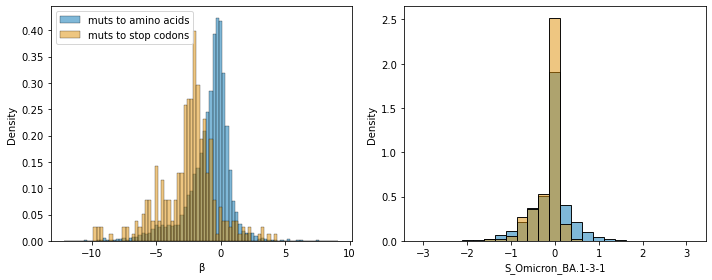

In [226]:
# Make a dataframe with inferred mutational effects
def split_sub(sub_string):
    """String match the wt, site, and sub aa
    in a given string denoting a single substitution"""

    pattern = r'(?P<aawt>[A-Z\*])(?P<site>[\d\w]+)(?P<aamut>[A-Z\*])'
    match = re.search(pattern, sub_string)
    assert match != None, sub_string
    return match.group('aawt'), match.group('site'), match.group('aamut')

mut_effects_dict = {
    key : []
    for key in ['wt', 'site', 'mut', 'param', 'param_val']
}
for (i, param) in enumerate(["β", f"S_{homolog_2}"]):
    if param in params:
        for (mutation, param_val) in zip(all_subs, params[param]):
            (wt, site, mut) = split_sub(mutation)
            mut_effects_dict['wt'].append(wt)
            mut_effects_dict['site'].append(int(site))
            mut_effects_dict['mut'].append(mut)
            mut_effects_dict['param'].append(param)
            mut_effects_dict['param_val'].append(float(param_val))
        
mut_effects_df = pd.DataFrame(mut_effects_dict)

(fig, axs) = plt.subplots(ncols=2, figsize=[10,4])
for (i, param) in enumerate(["β", f"S_{homolog_2}"]):
    
    # Plot data for all mutations
    data = mut_effects_df[
        (mut_effects_df['mut'] != '*') &
        (mut_effects_df['param'] == param)
    ]
    bin_width = 0.25
    min_val = math.floor(data['param_val'].min()) - 0.25/2
    max_val = math.ceil(data['param_val'].max())
    sns.histplot(
        x='param_val', data=data, ax=axs[i],
        stat='density', color=pal.as_hex()[0],
        label='muts to amino acids',
        binwidth=bin_width, binrange=(min_val, max_val),
        alpha=0.5
    )
    
    # Plot data for mutations leading to stop codons
    data = mut_effects_df[
        (mut_effects_df['mut'] == '*') &
        (mut_effects_df['param'] == param)
    ]
    sns.histplot(
        x='param_val', data=data, ax=axs[i],
        stat='density', color=pal.as_hex()[1],
        label='muts to stop codons',
        binwidth=bin_width, binrange=(min_val, max_val),
        alpha=0.5
    )
    
    axs[i].set(xlabel=param)

plt.tight_layout()
axs[0].legend()
plt.show()

To do for presenting to Jesse and Bernadeta:
* discuss w/ Jared:
    * differences between w/in homolog comparisons
    * new fitting strategy?
        * fit each homolog independently, then initialize joint fit with betas of reference?
        * come up w/ way to make datasets comparable
        * compare position of wt on sigmoid
        * add param to shift functional scores in non-reference homolog (could do this based on difference of wt on sigmoid?)
    * change loss function to be less sensitive to outliers? And to force sigmoid to go through the origin?

* updates for Jared
    * wildtype for omicron was getting filtered out! Due to indices being duplicated in many cases
    
* Question for 

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(2, figsize=(25, 10))

# non_identical_sites = [
#     i for i, row in site_map.iterrows()
#     if row["Delta"] != row["Omicron_BA.1"]
# ]

def split_sub(sub_string):
    """String match the wt, site, and sub aa
    in a given string denoting a single substitution"""

    pattern = r'(?P<aawt>[A-Z\*])(?P<site>[\d\w]+)(?P<aamut>[A-Z\*])'
    match = re.search(pattern, sub_string)
    assert match != None, sub_string
    return match.group('aawt'), match.group('site'), match.group('aamut')

for i, param in enumerate(["β", "S_Omicron_BA.1"]):
    rows = []
    for mutation, p in zip(all_subs, params[param]):
        wt, site, mut = split_sub(mutation)
        rows.append([int(site), wt, mut, float(p)])
        
    mutation_effects = pd.DataFrame(
        rows,
        columns=("site", "wildtype", "mutant", param)
    ).pivot(
        index="mutant",
        columns="site", values=param
    )#.iloc[:, :100]
    
    sns.heatmap(
        mutation_effects, 
        mask=mutation_effects.isnull(),
        cmap="coolwarm_r",
        center=0,
        cbar_kws={"label": param},
        ax=ax[i]
    )
    ax[i].set_title(f"{param}", size=20)

    
plt.tight_layout()
fig.savefig(f"{fig_saveas_prefix}-heatmap.png")
plt.show()

In [ ]:
# Plot data
# min_val = mut_effects_df['param_val'].min()
# max_val = mut_effects_df['param_val'].max()
# nbins = 20
# bin_size = (max_val - min_val) / nbins
# bins = onp.arange(min_val-bin_size/2, max_val+bin_size, bin_size)
# data = mut_effects_df[(mut_effects_df['mut'] == '*')]
# sns.histplot(x='param_val', data=data, hue='param', bins=bins)
# plt.tight_layout()
# sns.despine()
# plt.show()